# Exploring Solar Power Production Data

## Overview

Data on weekly power production from a subset of large photovoltaic installations in california is openly available from the website of The California Solar Iniative.  
http://www.gosolarcalifornia.ca.gov/csi/index.php.

Cleaned datasets are available to download from https://github.com/jmaurit/solar_prod or git users can cloan the repository https://github.com/jmaurit/solar_prod.git.  

There are several potentially interesting research questions that could utilize this data. 
Here I quickly go through some of the data in a few charts using Python/Pandas. 

In [18]:
import pandas as pd #for organizing and munging data - like R dataframe
import numpy as np #numerical computations and datatypes
import matplotlib.pyplot as plt #for plotting
import seaborn as sns #makes plots pretty and some easier
import matplotlib.patches as mpatches


### Load data

I have cleaned the data into two files. The first is a "long" file with about 125,000 individual observations.

In [2]:
prod_long=pd.read_csv("/Users/johannesmauritzen/research/solar_prod/prod_long.csv")
prod_long["prod_end_date"]=pd.to_datetime(prod_long["prod_end_date"])


I have also put together another dataset, "wide", that merges the above dataset with more extensive information on the solar panel installation like the contractor, manufacturer, etc.  But this dataset has substantially fewer datapoints: only about 9000 data points. 

In [3]:
prod_wide=pd.read_csv("/Users/johannesmauritzen/research/solar_prod/prod_wide.csv")
prod_wide["prod_end_date"]=pd.to_datetime(prod_wide["prod_end_date"])
prod_wide["complete_date"]=pd.to_datetime(prod_wide["complete_date"])


Here we can see what the long data looks like

In [4]:
prod_long.head()

,app_num,prog_admin,program,tot_cost,own_sect,host_cust_sect,cust_city,cust_county,cust_zip,pbi_payment_num,prod_end_date,prod_kwh
0,SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536639.6,Commercial,Commercial,San Diego,San Diego,92121,1,2007-05-31,36578
1,SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536639.6,Commercial,Commercial,San Diego,San Diego,92121,2,2007-06-30,41303
2,SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536639.6,Commercial,Commercial,San Diego,San Diego,92121,3,2007-07-31,38116
3,SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536639.6,Commercial,Commercial,San Diego,San Diego,92121,4,2007-08-31,35243
4,SD-CSI-00001,CSE,Large Commercial (>= 10 kW),1536639.6,Commercial,Commercial,San Diego,San Diego,92121,5,2007-09-30,36143


We can look at what the time series of production for one of these panels looks like

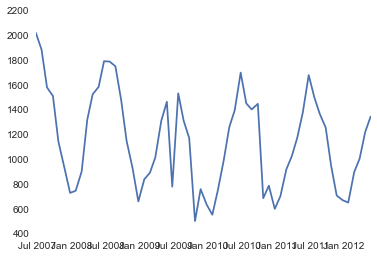

In [5]:
single=prod_long[prod_long.app_num=="SD-CSI-00005"]

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(single["prod_end_date"], single["prod_kwh"])
plt.show()

Now lets look at the production profiles of a group of panels.  But first, we normalize the production by dividing by each panels max production

In [6]:
prod_long["prod_max"]=prod_long.groupby("app_num")["prod_kwh"].transform(max)
prod_long["prod_index"] = prod_long["prod_kwh"]/prod_long["prod_max"]


In [7]:
prod_long=prod_long.set_index(["app_num", "prod_end_date"]) #set index
prod_long=prod_long.sort()

In [8]:
multi=prod_long.loc['PGE-CSI-00001':'PGE-CSI-00010']
multi.reset_index(inplace=True)


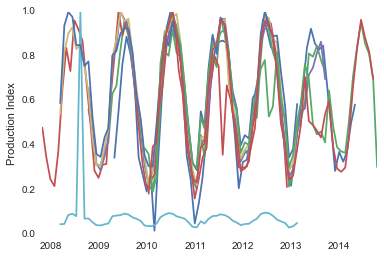

In [9]:
fig, ax = plt.subplots()
for system, i in multi.groupby("app_num"):
	ax.plot(i["prod_end_date"], i["prod_index"])
ax.set_ylabel("Production Index")
plt.show()

From this chart we can see that there are likely some data problems in the dataset. Probably someone that entered a data point with the digit in the wrong place

let's look at a cross section

In [10]:
prod_long.reset_index(inplace=True)
cross_section=prod_long.groupby("app_num").apply(lambda x: x.iloc[0])
cross_section=cross_section.rename(columns={'prod_end_date': 'first_prod', 
	'prod_kwh': 'avg_prod_kwh'})

Here is a histogram of costs

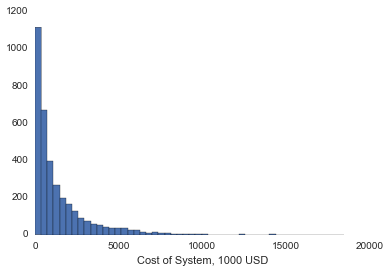

In [11]:
fig, ax = plt.subplots()
ax.hist(cross_section["tot_cost"]/1000, bins=50)
ax.set_xlabel("Cost of System, 1000 USD")
plt.show()

And average weekly production

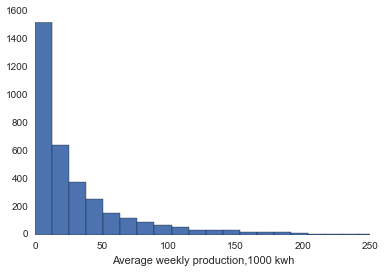

In [12]:
fig, ax = plt.subplots()
ax.hist(cross_section["avg_prod_kwh"]/1000, bins=50)
ax.set_xlabel("Average weekly production,1000 kwh")
ax.set_xlim([0,250])
plt.show()

We want to get a normalized measure of cost, but in this dataset, no measure of the capacity of the solar panels is given so we can not create a per kw measure.  Instead, lets take the maximum of weekly production and divide the total cost by that. 

In [13]:
cross_section["cost_per_max_kwh"]=cross_section["tot_cost"]/cross_section["prod_max"]
cross_section.sort("first_prod", inplace=True)


Then we can chart by the type of system owner: Blue: Commercial, Red: Residential, Green: Government, Yellow: Non-profit

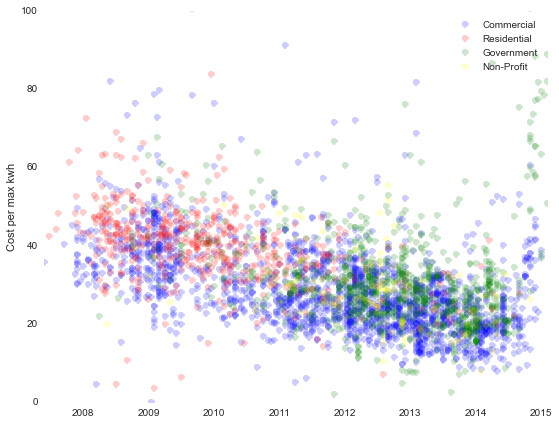

In [38]:
sectors= cross_section["own_sect"].unique()
colors=["blue", "red", "green", "yellow"]
sectorsZ=zip(sectors.tolist(), colors)

fig, ax = plt.subplots()
fig.set_size_inches(9,7)
for sect in sectorsZ:
	own_sect, color = sect
	ax.plot_date(x=cross_section.loc[cross_section["own_sect"]==own_sect,"first_prod"], 
		y=cross_section.loc[cross_section["own_sect"]==own_sect,"cost_per_max_kwh"],
		alpha=.2, color=color,  label=own_sect)
ax.set_ylabel("Cost per max kwh")
ax.set_ylim([0,100])
plt.legend()


Some interesting trends: Government and non-profit become more common, and residential more or less drop out of the dataset - this could be do to regulations or changes in the subsidy.  Commercial installations are consistently cheaper it looks like.  

## Potential research questions

Solar panels are known to become less efficient over time.  Can you detect this in the data? Can you estimate the rate of deterioration? 

Do some types of installations show more deterioration than others?  Are newer panels better, worse, the same?  Is there a correlations with the price?